# Analysis of Fishing Activity in the South China Sea, 2013-2020
William Jenkins
<br>GPPS 400: International Relations of the Asia-Pacific
<br>Dataset Project

## 1. Data Processing

### 1.1 Set up environment

Set up the environment by importing required modules and setting paths.  The project structure should be set up as follows:

```
/Project Folder                                  *
├── /Data                                        *
│   ├── /GFW                                     *
│   │   └── /fleet-daily                         *
│   │       ├── /fleet-daily-csvs-100-v2-2012    *
│   │       │   ├──2012-01-01.csv                *
│   │       │   ├──2012-01-02.csv                *
│   │       │   │       ...                      *
│   │       │   └──2012-12-31.csv                *
│   │       │               ...                  *
│   │       ├── /fleet-daily-csvs-100-v2-2020    *
│   │       └── README-fleet-v2.txt              *
│   ├── /Mapping                                 *
│   └── /Processed                               * <- Script output
├── /References                                  *
├── /Reports                                     *
│   └── /Figures                                 * <- Figures saved
└── /Source                                      *
    ├── /Notebooks                               *
    │   └── SCS_FishingAnalysis.ipynb            * <- This notebook
    ├── /SCS                                     *
    │   └── scs.py                               * <- Module/script
    └── scs.yml                                  * <- Conda YAML
```

In [35]:
from datetime import datetime
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

modulepath = (Path.cwd().parent / "SCS").as_posix()
if modulepath not in sys.path:
    sys.path.insert(0, modulepath)
import scs

sns.set_context("notebook")
sns.set_theme()

path_to_data = Path.cwd().parent.parent / "Data"
path_to_figures = Path.cwd().parent.parent / "Reports" / "Figures"
saveflag = True # Control whether figures will be saved.

### 1.2 Process raw data

<b>Usage</b><br>
The following command will process all data:
<br>`python3 ../SCS/scs.py <SAVENAME> --path <SAVEPATH> --start <YYYY-MM-DD> --stop <YYYY-MM-DD> --nw <NUM_WORKERS>`

<b>Required Parameters</b><br>
`<SAVENAME>`: Name of the output files.

<b>Optional Parameters</b><br>
`--savepath <SAVEPATH>`: Path to the desired output directory (default is `/Project Folder/Data/Processed`).<br>
`--start <YYYY-MM-DD>`: First day to be processed (default is `2012-01-01`).<br>
`--stop <YYYY-MM-DD>`: Last day +1 to be processed (default is `2021-01-01`).<br>
`--nw <NUM_WORKERS>`: Number of parallel processors (default is `1`).

<b>Example</b><br>
The following command runs the processing script and outputs files named `test.npy` and `test.csv` using data from 25 Dec 2014 and 26 Dec 2014 (notice the `stop` date is not inclusive), and uses 2 workers for parallel processing to speed up the script:<br>
`python3 ../SCS/scs.py test --start 2014-12-25 --stop 2014-12-27 --nw 2`

<b>Execution Time</b><br>
Processing the entire dataset on a 2019 Macbook Pro with 2.4 GHz 8-Core Intel Core i9 using 14 workers took 1 hr 30 min.

In [ ]:
! python3 ../SCS/scs.py test --start 2014-12-25 --end 2014-12-27 --nw 2

### 1.3 Load processed data & prepare for analysis

Load configuration information from file `config.pkl` into memory.

In [4]:
savename = "scs"
loadpath = path_to_data / "Processed"
config = scs.load_config(loadpath / f"{savename}.pkl")
countries = config["countries"] # All Countries

extent = config["extent"]
paths = config["paths"]
path_fishing = config["path_fishing"]

Create an instance of `GeographicData` to store EEZ spatial data.  The `countries` attribute will be used in the data analysis.

In [5]:
geodata = scs.GeographicData(paths=paths, countries=countries, extent=extent)
geodata.load_all()
EEZ = geodata.eez

Show map of region

In [ ]:
# fig = geodata.make_scs_map(savepath=path_to_figures / "scs_map.png")
fig = geodata.make_scs_map()

Create an instance of `FishingData`.  The `countries` attribute will be used in the data analysis.

In [6]:
countries=["CHN", "TWN", "VNM", "PHL", "MYS", "BRN"]
activity = scs.FishingData(
    path_fishing,
    countries=countries,
    extent=extent,
    crs=EEZ.gdf.crs
)
activity.set_dates(start="2012-12-01", end="2021-01-01")

Create an instance of `DataAnalyzer` to store the results of the data processing.  The methods contained in this class will be used to analyze data and create plots.

In [15]:
analyzer = scs.DataAnalyzer(activity, EEZ, loadpath / "scs")
activity.set_dates(start="2013-01-01", end="2021-01-01")
start_epoch = (datetime.strptime(activity.start, '%Y-%M-%d') - datetime(1970, 1, 1)).days
end_epoch = (datetime.strptime(activity.end, '%Y-%M-%d') - datetime(1970, 1, 1)).days
analyzer.df

Number of Ships                                  \
                           CHN     TWN    MYS  PHL  BRN    VNM   
Date       EEZ                                                   
2013-01-01 CHN         11677.0     0.0    0.0  0.0  0.0    0.0   
           TWN             0.0   459.0    0.0  0.0  0.0    0.0   
           MYS             0.0   103.0    0.0  0.0  0.0    0.0   
           PHL             0.0     0.0    0.0  0.0  0.0    0.0   
           BRN             0.0     0.0    0.0  0.0  0.0    0.0   
...                        ...     ...    ...  ...  ...    ...   
2020-12-31 TWN            45.0  1874.0    0.0  0.0  0.0    0.0   
           MYS            41.0    59.0  911.0  0.0  0.0    0.0   
           PHL             0.0     0.0    0.0  0.0  0.0    0.0   
           BRN             0.0     0.0    0.0  0.0  0.0    0.0   
           VNM             9.0     0.0    0.0  0.0  0.0  195.0   

               Number of Ship-Hours                                          \
                                CHN       TWN       MYS  PHL  BRN       VNM   
Date       EEZ                                                                
2013-01-01 CHN            5337.5698    0.0000    0.0000  0.0  0.0    0.0000   
           TWN               0.0000   69.2694    0.0000  0.0  0.0    0.0000   
           MYS               0.0000    0.0000    0.0000  0.0  0.0    0.0000   
           PHL               0.0000    0.0000    0.0000  0.0  0.0    0.0000   
           BRN               0.0000    0.0000    0.0000  0.0  0.0    0.0000   
...                             ...       ...       ...  ...  ...       ...   
2020-12-31 TWN               0.0000  332.1703    0.0000  0.0  0.0    0.0000   
           MYS               5.3997    0.0000  635.3266  0.0  0.0    0.0000   
           PHL               0.0000    0.0000    0.0000  0.0  0.0    0.0000   
           BRN               0.0000    0.0000    0.0000  0.0  0.0    0.0000   
           VNM               0.0000    0.0000    0.0000  0.0  0.0  132.6521   

               Number of Fishing Hours                                  \
                                   CHN        TWN        MYS  PHL  BRN   
Date       EEZ                                                           
2013-01-01 CHN              12628.3791     0.0000     0.0000  0.0  0.0   
           TWN                  0.0000   724.8696     0.0000  0.0  0.0   
           MYS                  0.0000   112.9146     0.0000  0.0  0.0   
           PHL                  0.0000     0.0000     0.0000  0.0  0.0   
           BRN                  0.0000     0.0000     0.0000  0.0  0.0   
...                                ...        ...        ...  ...  ...   
2020-12-31 TWN                 50.8593  1714.2894     0.0000  0.0  0.0   
           MYS                 17.4968    42.7913  1541.6087  0.0  0.0   
           PHL                  0.0000     0.0000     0.0000  0.0  0.0   
           BRN                  0.0000     0.0000     0.0000  0.0  0.0   
           VNM                 44.2277     0.0000     0.0000  0.0  0.0   

                         
                    VNM  
Date       EEZ           
2013-01-01 CHN    0.000  
           TWN    0.000  
           MYS    0.000  
           PHL    0.000  
           BRN    0.000  
...                 ...  
2020-12-31 TWN    0.000  
           MYS    0.000  
           PHL    0.000  
           BRN    0.000  
           VNM  377.789  

[17532 rows x 18 columns]

## 2. Analysis

### 2.1 Total Fishing Activity by Country

This section gives a broad overview of fishing undertaken by each of the SCS claimants.

#### 2.1.1 Number of unique vessels

The following figure shows the number of unique fishing vessels present in the SCS for each country, aggregated by month.

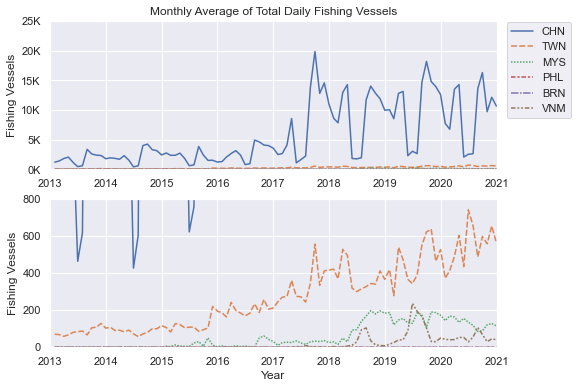

In [36]:
# Select data set
df = analyzer.df["Number of Ships"]
# Aggregate monthly totals
df = df.groupby(pd.Grouper(freq="M", level="Date"), axis=0).mean()

# Plot Data
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

g = sns.lineplot(data=df, ax=axs[0])
g.legend(bbox_to_anchor=(1.01, 1.03))
g.set(
    xlabel=None,
    ylabel="Fishing Vessels",
    title="Monthly Average of Total Daily Fishing Vessels",
    xlim=[start_epoch, end_epoch],
    ylim=0
)
yticklocs = g.get_yticks().tolist()
g.set_yticks(yticklocs)
g.set_yticklabels([f"{y/1e3:,.0f}K" for y in yticklocs])

g = sns.lineplot(data=df, ax=axs[1])
g.set(
    xlabel="Year",
    ylabel="Fishing Vessels",
    xlim=[start_epoch, end_epoch],
    ylim=[0, 800]
)
# yticklocs = g.get_yticks().tolist()
# g.set_yticks(yticklocs)
# g.set_yticklabels([f"{y/1e3:,.0f}K" for y in yticklocs])
g.legend_.remove()
if saveflag:
    fig.savefig(
        path_to_figures / "01_TotalVessels.png",
        dpi=300,
        bbox_inches="tight",
        facecolor='white'
    )
plt.show()

#### 2.1.2 Apparent fishing effort
The following figure shows the number of fishing hours that were undertaken by each claimant in the SCS, aggregated by month.

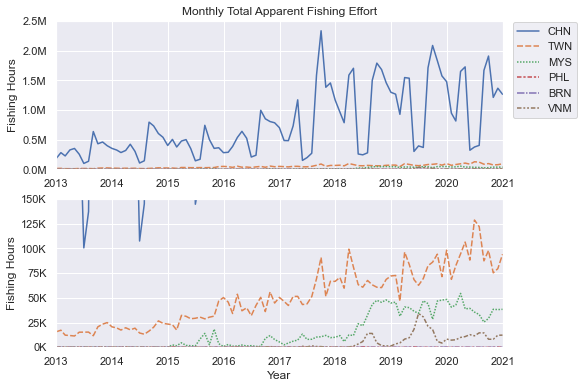

In [7]:
# Select data set
df = analyzer.df["Number of Fishing Hours"]
# Aggregate monthly totals
df = df.groupby(pd.Grouper(freq="M", level="Date"), axis=0).sum()

# Plot Data
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
sns.set_context("notebook")

g = sns.lineplot(data=df, ax=axs[0])
g.legend(bbox_to_anchor=(1.01, 1.03))
g.set(
    xlabel=None,
    ylabel="Fishing Hours",
    title="Monthly Total Apparent Fishing Effort",
    xlim=[start_epoch, end_epoch],
    ylim=0
)
yticklocs = g.get_yticks().tolist()
g.set_yticks(yticklocs)
g.set_yticklabels([f"{y/1e6:,.1f}M" for y in yticklocs])

g = sns.lineplot(data=df, ax=axs[1])
g.set(
    xlabel="Year",
    ylabel="Fishing Hours",
    xlim=[start_epoch, end_epoch],
    ylim=[0, 150000]
)
yticklocs = g.get_yticks().tolist()
g.set_yticks(yticklocs)
g.set_yticklabels([f"{y/1e3:,.0f}K" for y in yticklocs])
g.legend_.remove()
if saveflag:
    fig.savefig(
        path_to_figures / "01_TotalEffort.png",
        dpi=300,
        bbox_inches="tight",
        facecolor='white'
    )
plt.show()

#### 2.1.3 Total underway time

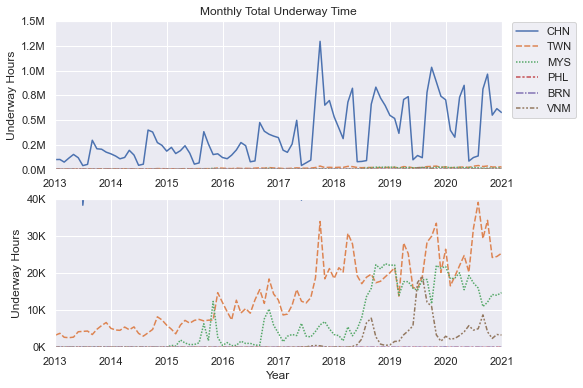

In [8]:
# Select data set
df = analyzer.df["Number of Ship-Hours"]
# Aggregate monthly totals
df = df.groupby(pd.Grouper(freq="M", level="Date"), axis=0).sum()

# Plot Data
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
# g = sns.relplot(data=df, kind="line", height=6, aspect=4/3, ax=axs[0])
g = sns.lineplot(data=df, ax=axs[0])
g.legend(bbox_to_anchor=(1.01, 1.03))
g.set(
    xlabel=None,
    ylabel="Underway Hours",
    title="Monthly Total Underway Time",
    xlim=[start_epoch, end_epoch],
    ylim=0
)
yticklocs = g.get_yticks().tolist()
g.set_yticks(yticklocs)
g.set_yticklabels([f"{y/1e6:,.1f}M" for y in yticklocs])
g = sns.lineplot(data=df, ax=axs[1])

# xticklabels = ['{:,.0f'}]
# axs[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
g.set(
    xlabel="Year",
    ylabel="Underway Hours",
    xlim=[start_epoch, end_epoch],
    ylim=[0, 40000]
)
yticklocs = g.get_yticks().tolist()
g.set_yticks(yticklocs)
g.set_yticklabels([f"{y/1e3:,.0f}K" for y in yticklocs])
g.legend_.remove()
if saveflag:
    fig.savefig(
        path_to_figures / "01_TotalUnderway.png",
        dpi=300,
        bbox_inches="tight",
        facecolor='white'
    )
plt.show()

### 2.2 EEZ Intrusions

#### 2.2.1 
In the following section, figures show intrusions in each claimant's EEZ by other claimants.

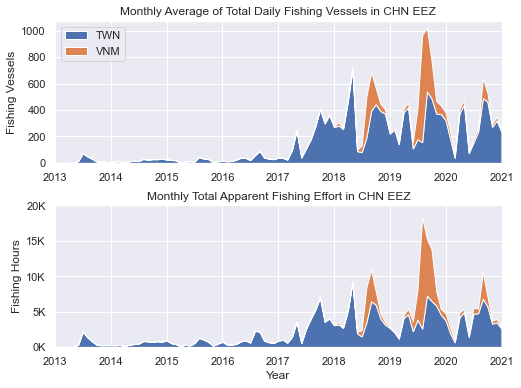

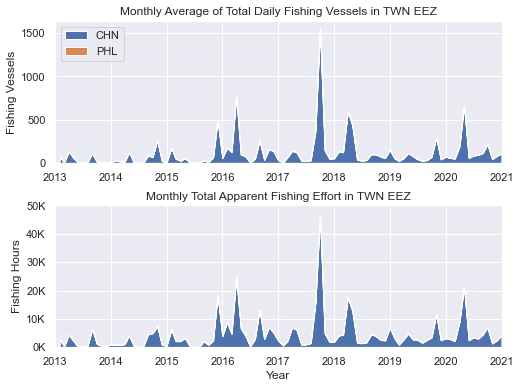

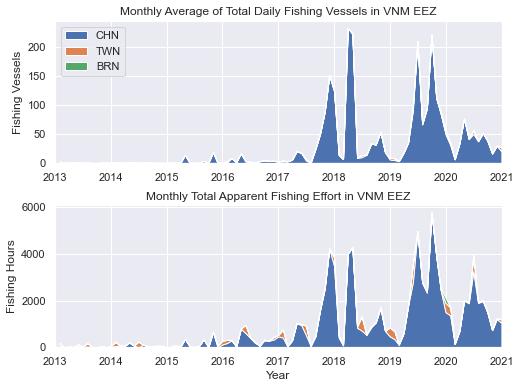

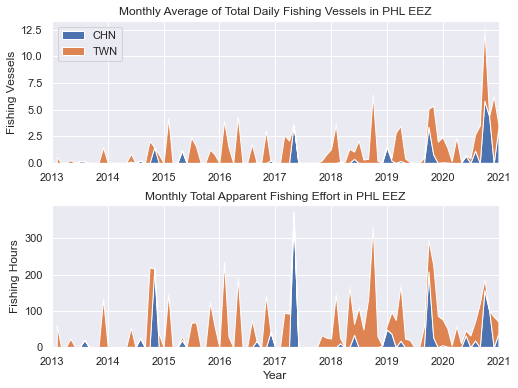

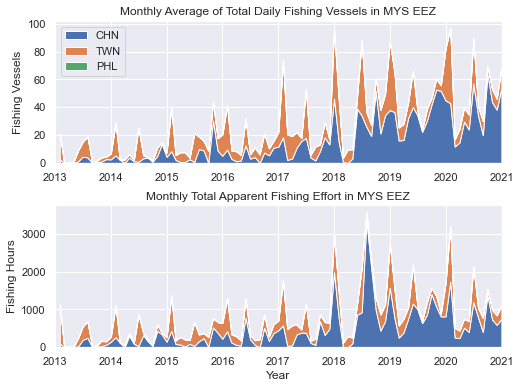

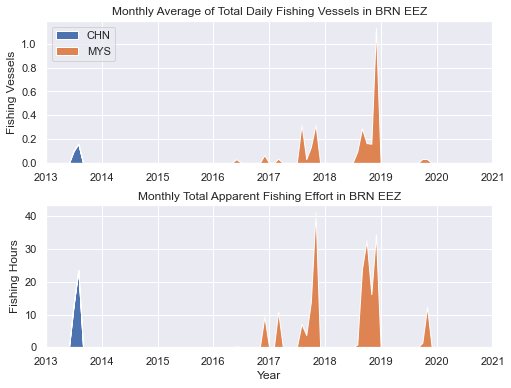

In [37]:
freq = "Monthly"

for selected_EEZ in countries:
# selected_EEZ = "CHN"

    selected_ships = [x for x in countries if x != selected_EEZ]

    variable = "Number of Ships"
    df0 = analyzer.df[variable]
    df0 = df0.loc[(slice(None), selected_EEZ), selected_ships]
    df0 = df0.groupby(pd.Grouper(freq=freq[0], level="Date"), axis=0).mean()

    variable = "Number of Fishing Hours"
    df1 = analyzer.df[variable]
    df1 = df1.loc[(slice(None), selected_EEZ), selected_ships]
    df1 = df1.groupby(pd.Grouper(freq=freq[0], level="Date"), axis=0).sum()

    # Filter columns with no data
    for country in selected_ships:
        if (df0[country].sum() == 0) & (df1[country].sum() == 0):
            df0 = df0.drop(labels=country, axis=1)
            df1 = df1.drop(labels=country, axis=1)

    selected_ships = df0.columns.to_list()

    df2 = df1.div(df1.sum(axis=1), axis=0) * 100

    fig, axs = plt.subplots(2, 1, figsize=(8, 6))
    # fig, axs = plt.subplots(3, 1, figsize=(8, 6))
    
    # Subplot 0
    axs[0].stackplot(df0.index, df0.values.T, labels=selected_ships)
    axs[0].set(
        xlabel=None,
        ylabel="Fishing Vessels",
        title=f"Monthly Average of Total Daily Fishing Vessels in {selected_EEZ} EEZ",
        xlim=[start_epoch, end_epoch],
        ylim=0
    )
    yticklocs = axs[0].get_yticks().tolist()
    if max(yticklocs) > 1e4:
        axs[0].set_yticks(yticklocs)
        axs[0].set_yticklabels([f"{y/1e3:,.0f}K" for y in yticklocs])
    axs[0].legend(loc="upper left")
    # g = sns.lineplot(data=df0, ax=axs[0])
    # g.set(xlabel=None, ylabel="Fishing Vessels", title=f"Monthly Total Fishing Vessels in {selected_EEZ} EEZ", xlim=[start_epoch, end_epoch], ylim=0)
    # g.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")
    # yticklocs = g.get_yticks().tolist()
    # if max(yticklocs) > 1e4:
    #     g.set_yticks(yticklocs)
    #     g.set_yticklabels([f"{y/1e3:,.0f}K" for y in yticklocs])

    # # Subplot 1
    # g = sns.lineplot(data=df1, ax=axs[1])
    # g.set(xlabel=None, ylabel="Fishing Hours", title=f"Monthly Total Apparent Fishing Effort in {selected_EEZ} EEZ", xlim=[start_epoch, end_epoch], ylim=0)
    # g.legend_.remove()
    # yticklocs = g.get_yticks().tolist()
    # if max(yticklocs) > 1e4:
    #     g.set_yticks(yticklocs)
    #     g.set_yticklabels([f"{y/1e3:,.0f}K" for y in yticklocs])

    # Subplot 2
    axs[1].stackplot(df1.index, df1.values.T, labels=selected_ships)
    axs[1].set(
        xlabel="Year",
        ylabel="Fishing Hours",
        title=f"Monthly Total Apparent Fishing Effort in {selected_EEZ} EEZ",
        xlim=[start_epoch, end_epoch],
        ylim=0
    )
    yticklocs = axs[1].get_yticks().tolist()
    if max(yticklocs) > 1e4:
        axs[1].set_yticks(yticklocs)
        axs[1].set_yticklabels([f"{y/1e3:,.0f}K" for y in yticklocs])

    plt.subplots_adjust(hspace=0.3)
    if saveflag:
        fig.savefig(
            path_to_figures / f"02_EEZ_Total_{selected_EEZ}.png",
            dpi=300,
            bbox_inches="tight",
            facecolor='white'
        )
    plt.show()

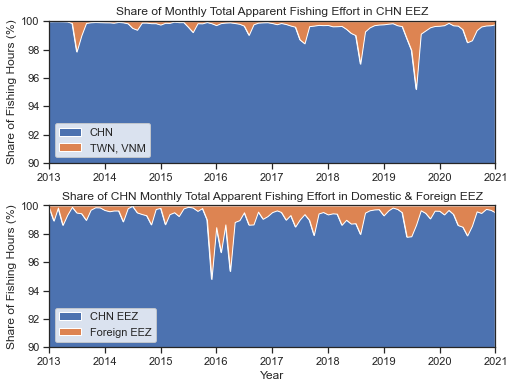

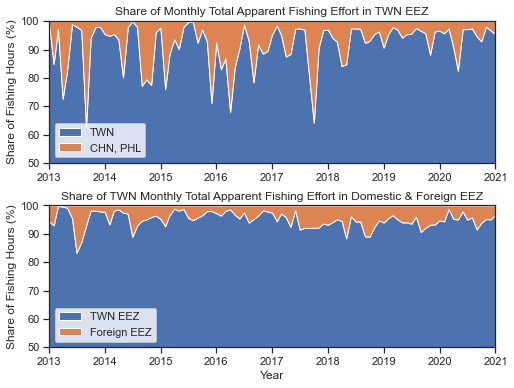

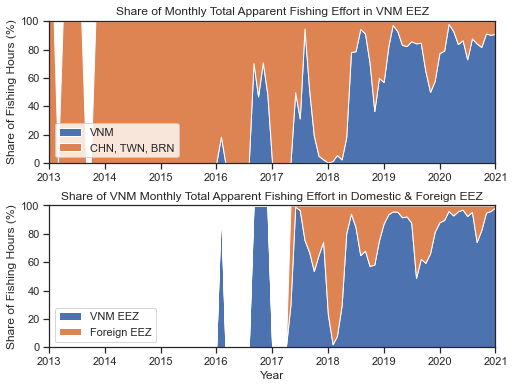

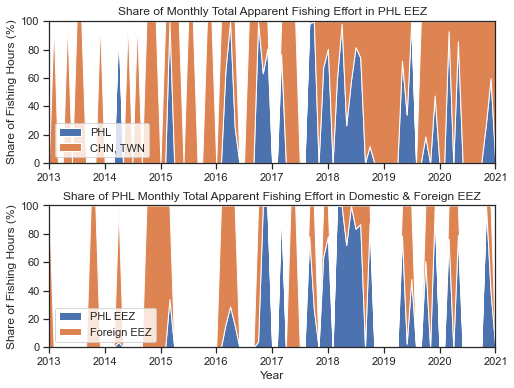

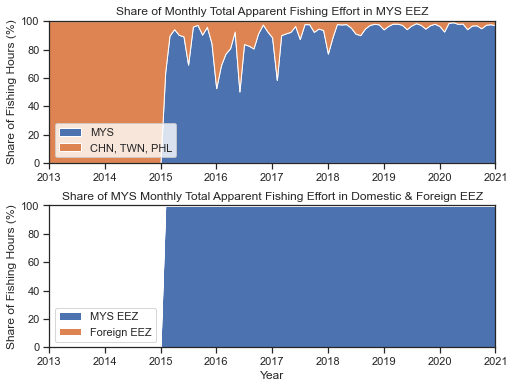

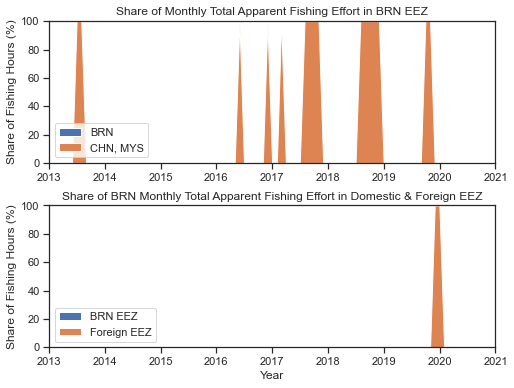

In [18]:
freq = "Monthly"
sns.set_theme(style="ticks")

for selected_EEZ in countries:
# selected_EEZ = "CHN"

    selected_ships = [x for x in countries if x != selected_EEZ]
    variable = "Number of Fishing Hours"

    # Own ships in EEZ
    df0 = analyzer.df[variable]
    df0 = df0.loc[(slice(None), selected_EEZ), selected_EEZ]
    df0 = df0.groupby(pd.Grouper(freq=freq[0], level="Date"), axis=0).sum()

    # Foreign ships in EEZ
    df1 = analyzer.df[variable]
    df1 = df1.loc[(slice(None), selected_EEZ), selected_ships]
    df1 = df1.groupby(pd.Grouper(freq=freq[0], level="Date"), axis=0).sum()

    # Filter columns with no data
    for country in selected_ships:
        if df1[country].sum() == 0:
            df1 = df1.drop(labels=country, axis=1)

    # Own ships in foreign EEZ
    df2 = analyzer.df[variable]
    df2 = df2.query(f'EEZ != "{selected_EEZ}"')
    df2 = df2.groupby(pd.Grouper(freq=freq[0], level="Date"), axis=0).sum()
    df2 = df2[selected_EEZ]

    selected_ships = df1.columns.to_list()
    labels = [selected_EEZ, ', '.join(selected_ships)]

    # Calculate share of foreign vs. domestic fishing hours in own EEZ
    df_for = pd.concat([df0, df1.sum(axis=1)], axis=1)
    df_for = df_for.div(df_for.sum(axis=1), axis=0) * 100
    df_for = df_for.fillna(value=0)
    df_for = df_for.rename(
        columns={selected_EEZ: selected_EEZ, 0: ', '.join(selected_ships)}
    )

    # Calculate share of own fishing effort in foreign vs. own EEZ
    df_dom = pd.concat([df0, df2], axis=1)
    df_dom = df_dom.div(df_dom.sum(axis=1), axis=0) * 100
    df_dom = df_dom.fillna(value=0)
    df_dom.columns = [f"{selected_EEZ} EEZ", "Foreign EEZ"]

    # df_dom = df_dom.div(df_dom.sum(axis=1).)

    fig, axs = plt.subplots(2, 1, figsize=(8, 6))
    

    # Chart 1: Share of Foreign vs. Domestic Fishing Hours within EEZ
    axs[0].stackplot(df_for.index, df_for.values.T, labels=labels)
    if selected_EEZ == "CHN":
        ylim0 = [90, 100]
        ylim1 = ylim0
    elif selected_EEZ == "TWN":
        ylim0 = [50, 100]
        ylim1 = ylim0
    else:
        ylim0 = [0, 100]
        ylim1 = ylim0
    axs[0].set(
        xlabel=None,
        ylabel="Share of Fishing Hours (%)",
        title=f"Share of Monthly Total Apparent Fishing Effort in {selected_EEZ} EEZ",
        xlim=[start_epoch, end_epoch],
        ylim=ylim0
    )
    axs[0].legend(loc="lower left")

    # Chart 2: Country Domestic vs. Foreign Share of Fishing Hours
    axs[1].stackplot(df_dom.index, df_dom.values.T, labels=df_dom.columns)
    axs[1].set(
        xlabel="Year",
        ylabel="Share of Fishing Hours (%)",
        title=f"Share of {selected_EEZ} Monthly Total Apparent Fishing Effort in Domestic & Foreign EEZ",
        xlim=[start_epoch, end_epoch],
        ylim=ylim1
    )
    axs[1].legend(loc="lower left")
    plt.subplots_adjust(hspace=0.3)
    if saveflag:
        fig.savefig(
            path_to_figures / f"03_EEZ_Share_{selected_EEZ}.png",
            dpi=300,
            bbox_inches="tight",
            facecolor='white'
        )
    plt.show()

#### 2.2.2 Share of EEZ intrusions

In this figure, the intent is to display which country is the worst offender in terms of violating EEZs.

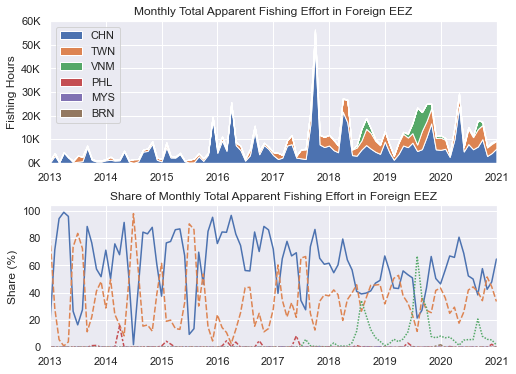

In [23]:
df = analyzer.df["Number of Fishing Hours"]

df_total = []
for country in countries:
    df_int = df.query(f'EEZ != "{country}"')
    df_int = df_int.groupby(
        pd.Grouper(freq=freq[0], level="Date"), axis=0
    ).sum()
    df_total.append(df_int[country])
df_total = pd.concat(df_total, axis=1)
df_share = df_total.div(df_total.sum(axis=1), axis=0) * 100

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# g = sns.lineplot(data=df_total, ax=axs[0])
axs[0].stackplot(df_total.index, df_total.values.T, labels=countries)
axs[0].set(
    xlabel=None,
    ylabel="Fishing Hours",
    title=f"Monthly Total Apparent Fishing Effort in Foreign EEZ",
    xlim=[start_epoch, end_epoch],
    ylim=0
)
axs[0].legend(loc="upper left")
yticklocs = axs[0].get_yticks().tolist()
if max(yticklocs) > 1e4:
    axs[0].set_yticks(yticklocs)
    axs[0].set_yticklabels([f"{y/1e3:,.0f}K" for y in yticklocs])
# g.set(xlabel=None, ylabel="Fishing Vessels", title=f"Monthly Total Apparent Fishing Effort in Foreign EEZ", xlim=[start_epoch, end_epoch], ylim=0)
# g.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")

g = sns.lineplot(data=df_share, ax=axs[1])
g.legend_.remove()
g.set(
    xlabel=None,
    ylabel="Share (%)",
    title=f"Share of Monthly Total Apparent Fishing Effort in Foreign EEZ",
    xlim=[start_epoch, end_epoch],
    ylim=0
)
# axs[2].stackplot(df_share.index, df_share.values.T)
# axs[2].set(xlabel=None, ylabel="Share (%)", title=f"Share of Monthly Total Apparent Fishing Effort in Foreign EEZ", xlim=[start_epoch, end_epoch], ylim=[0, 100])

plt.subplots_adjust(hspace=0.3)
if saveflag:
    fig.savefig(
        path_to_figures / "04_TotalForeignEEZ.png",
        dpi=300,
        bbox_inches="tight",
        facecolor='white'
    )
plt.show()

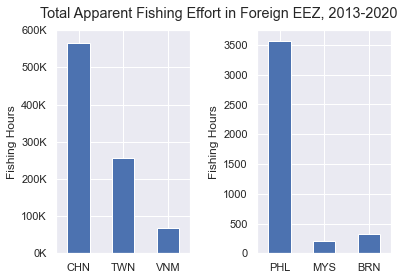

In [22]:
df = analyzer.df["Number of Fishing Hours"]

df_total = []
for country in countries:
    df_int = df.query(f'EEZ != "{country}"')
    df_int = df_int.groupby(
        pd.Grouper(freq=freq[0], level="Date"), axis=0
    ).sum()
    df_total.append(df_int[country])
df_total = pd.concat(df_total, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(6, 4))

df_total[["CHN", "TWN", "VNM"]].sum().plot.bar(rot=0, ax=axs[0])
yticklocs = axs[0].get_yticks().tolist()
if max(yticklocs) > 1e4:
    axs[0].set_yticks(yticklocs)
    axs[0].set_yticklabels([f"{y/1e3:,.0f}K" for y in yticklocs])
axs[0].set_ylabel("Fishing Hours")

df_total[["PHL", "MYS", "BRN"]].sum().plot.bar(rot=0, ax=axs[1])
yticklocs = axs[1].get_yticks().tolist()
if max(yticklocs) > 1e4:
    axs[1].set_yticks(yticklocs)
    axs[1].set_yticklabels([f"{y/1e3:,.0f}K" for y in yticklocs])
axs[1].set_ylabel("Fishing Hours")

plt.suptitle("Total Apparent Fishing Effort in Foreign EEZ, 2013-2020")
plt.subplots_adjust(wspace=0.5, top=0.9)
if saveflag:
    fig.savefig(
        path_to_figures / "05_TotalForeignEffortBar.png",
        dpi=300,
        bbox_inches="tight",
        facecolor='white'
    )
plt.show()